## DATA PREPAIRING

In [5]:
%%capture
!pip install transformers
!pip install tqdm

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import AutoModel, AutoTokenizer, AdamW
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

In [8]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [9]:
!nvidia-smi

Fri Jul 21 09:38:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [10]:
train_path = '/kaggle/input/aclimdb/aclImdb/train'
test_path = '/kaggle/input/aclimdb/aclImdb/test'

train_dict = {'Text': [], 'Rating': []}
test_dict = {'Text': [], 'Rating': []}
for dir_name in os.listdir(train_path):
    if dir_name in ['pos', 'neg']:
        for file_name in os.listdir(train_path+'/'+dir_name):
            file_path = os.path.join(train_path+'/'+dir_name, file_name)
            with open(file_path, 'r') as file:
                train_dict['Text'].append(file.read())
                train_dict['Rating'].append(int(re.search(r'\d+_(\d+)\.txt', file_name).group(1)))
for dir_name in os.listdir(test_path):
    if dir_name in ['pos', 'neg']:
        for file_name in os.listdir(test_path+'/'+dir_name):
            file_path = os.path.join(test_path+'/'+dir_name, file_name)
            with open(file_path, 'r') as file:
                test_dict['Text'].append(file.read())
                test_dict['Rating'].append(int(re.search(r'\d+_(\d+)\.txt', file_name).group(1)))

In [11]:
train_df = pd.DataFrame.from_dict(train_dict)
train_df.head(5)

,Text,Rating
0,This was one of those wonderful rare moments i...,10
1,Have you seen The Graduate? It was hailed as t...,10
2,"I don't watch a lot of TV, except for The Offi...",8
3,Kubrick again puts on display his stunning abi...,10
4,"First of all, I liked very much the central id...",8


In [12]:
test_df = pd.DataFrame.from_dict(test_dict)
test_df.head(5)

,Text,Rating
0,"I've Seen The Beginning Of The Muppet Movie, B...",10
1,If it had been made 2 years later it would hav...,9
2,"Very good ""Precoder"" starring Dick Barthelmess...",8
3,A young man discovers that life is precious af...,10
4,"I'm always surprised, given that the famous ti...",10


In [13]:
OHenc_train_df = pd.get_dummies(train_df, columns=['Rating'])
OHenc_train_df

,Text,Rating_1,Rating_2,Rating_3,Rating_4,Rating_7,Rating_8,Rating_9,Rating_10
0,This was one of those wonderful rare moments i...,0,0,0,0,0,0,0,1
1,Have you seen The Graduate? It was hailed as t...,0,0,0,0,0,0,0,1
2,"I don't watch a lot of TV, except for The Offi...",0,0,0,0,0,1,0,0
3,Kubrick again puts on display his stunning abi...,0,0,0,0,0,0,0,1
4,"First of all, I liked very much the central id...",0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...
24995,The first hour of the movie was boring as hell...,0,0,0,1,0,0,0,0
24996,"A fun concept, but poorly executed. Except for...",0,0,0,1,0,0,0,0
24997,I honestly don't understand how tripe like thi...,1,0,0,0,0,0,0,0
24998,This remake of the 1962 orginal film'o the boo...,1,0,0,0,0,0,0,0


In [14]:
OHenc_test_df = pd.get_dummies(test_df, columns=['Rating'])
OHenc_test_df

,Text,Rating_1,Rating_2,Rating_3,Rating_4,Rating_7,Rating_8,Rating_9,Rating_10
0,"I've Seen The Beginning Of The Muppet Movie, B...",0,0,0,0,0,0,0,1
1,If it had been made 2 years later it would hav...,0,0,0,0,0,0,1,0
2,"Very good ""Precoder"" starring Dick Barthelmess...",0,0,0,0,0,1,0,0
3,A young man discovers that life is precious af...,0,0,0,0,0,0,0,1
4,"I'm always surprised, given that the famous ti...",0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
24995,This is one of those inoffensive and mildly en...,0,0,0,1,0,0,0,0
24996,When people say children are annoying u think ...,0,0,0,1,0,0,0,0
24997,"OK, I don't want to upset anyone who enjoyed t...",0,0,1,0,0,0,0,0
24998,Words can scarcely describe this movie. Loaded...,0,1,0,0,0,0,0,0


In [15]:
attributes = ['Rating_1', 'Rating_2', 'Rating_3', 'Rating_4', 'Rating_7', 'Rating_8', 'Rating_9', 'Rating_10']

## EDA

<Axes: >

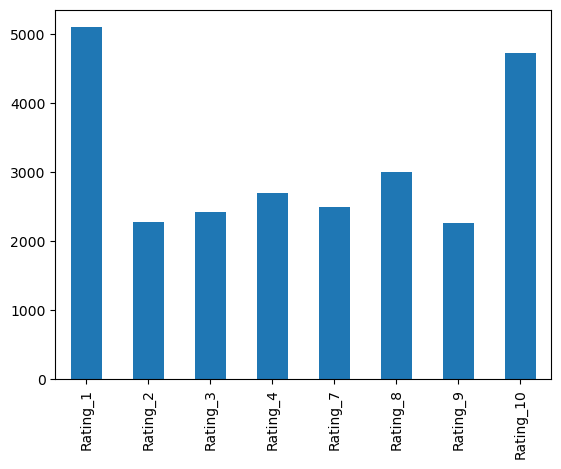

In [16]:
OHenc_train_df[attributes].sum().plot.bar()

In [17]:
max_len_train = OHenc_train_df['Text'].str.split().apply(len).max()
max_len_test = test_df['Text'].str.split().apply(len).max()
max_len_train, max_len_test

(2470, 2278)

In [18]:
df = pd.DataFrame()

In [19]:
df['Review Length Train'] = OHenc_train_df['Text'].str.split().apply(len)
df['Review Length Test'] = test_df['Text'].str.split().apply(len)

In [20]:
df

,Review Length Train,Review Length Test
0,148,131
1,765,176
2,249,168
3,130,99
4,165,381
...,...,...
24995,50,154
24996,231,159
24997,37,142
24998,262,142


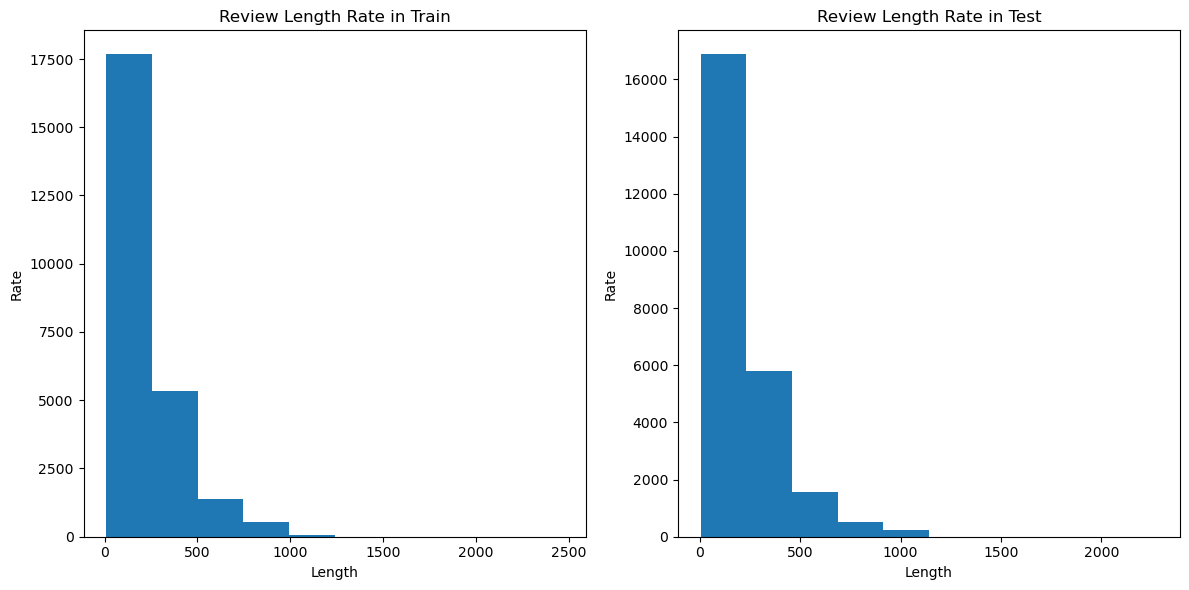

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.hist(df['Review Length Train'])
ax1.set_title('Review Length Rate in Train')
ax1.set_xlabel('Length')
ax1.set_ylabel('Rate')

ax2.hist(df['Review Length Test'])
ax2.set_title('Review Length Rate in Test')
ax2.set_xlabel('Length')
ax2.set_ylabel('Rate')

plt.tight_layout()
plt.show()

### Рецензий длиной > 256 мало (а ещё большие тексты не влезают на видеокарту), поэтому при обучении roberta будем обрезать слишком большие тексты, так как информативно для обучения почти ничего не теряем.

## DATASET

In [22]:
from torch.utils.data import Dataset

In [23]:
class ACLIMDB_Dataset(Dataset):
    def __init__(self, data, tokenizer, attributes, max_length: int = 256):
        self.data = data
        self.tokenizer = tokenizer
        self.attributes = attributes
        self.max_length = max_length
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        review = str(item['Text'])
        attributes = torch.FloatTensor(item[self.attributes])
        tokens = self.tokenizer.encode_plus(
            review,
            max_length = self.max_length,
            add_special_tokens = True,
            truncation = True,
            padding = 'max_length',
            return_tensors = 'pt',
            return_attention_mask = True
        )
        return {'input_ids': tokens.input_ids.flatten(), 'attention_mask': tokens.attention_mask.flatten(), 'labels': attributes}

In [24]:
model_name = 'roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

In [25]:
df_train, df_val = train_test_split(OHenc_train_df, train_size=0.8, random_state=42)

In [26]:
train_dataset = ACLIMDB_Dataset(df_train, tokenizer, attributes)
val_dataset = ACLIMDB_Dataset(df_val, tokenizer, attributes)
test_dataset = ACLIMDB_Dataset(OHenc_test_df, tokenizer, attributes)

In [27]:
train_dataset.__getitem__(0)

{'input_ids': tensor([    0,   100,   581,   224,    42,   203,  5579,   713,   736,    16,
            70,    59, 23112,  3156,   734, 34331,   144,     9,   201,    32,
            45,  1227,     7, 10749,   471,    12,   261,     4,  2209,     9,
          2099,     6,  4260,     6,  1900,     6,     8,    82,    22,  5982,
         31794,  1235,   113,    32,  5861,  4840, 16014,     5, 18754,     6,
            61,   817,   162,  5170,   114,     5,   736,    21,   667,     7,
          8469,     5,  4286,     9,  3500,    50,   800,     4,  2223,    38,
           218,    75,   206,    14,    38,   115,   655,   192,    42,  1569,
           456,     6,    38,    40,   224,    14,     5,   736,   473,    33,
            10,   205,  2295,     4,   345,    58,   103,   269,  2579,  2347,
             8,    22, 37587,  3423,   113,    11,     5,   822,    36,   627,
           841,     6,     5,  8869,  3539,    11,    49,  2549,   238,    53,
             5,   527,   314,   162, 12

In [28]:
len(train_dataset), len(test_dataset), len(val_dataset)

(20000, 25000, 5000)

## DATALOADERS AND MODEL

In [109]:
batch_size=32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers = 4, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers = 4, shuffle = False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers = 4, shuffle = False)

In [110]:
len(train_dataloader), len(val_dataloader), len(test_dataloader)

(625, 157, 782)

In [111]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [112]:
class ACLIMDB_Rating_Classifier(nn.Module):
    def __init__(self, config):
        super(ACLIMDB_Rating_Classifier, self).__init__()
        self.config = config
        self.pretrained_model = AutoModel.from_pretrained(self.config['model_name'])
        self.h_layer = nn.Linear(in_features = self.pretrained_model.config.hidden_size,
                       out_features = self.pretrained_model.config.hidden_size)
        self.c_head = nn.Linear(in_features = self.pretrained_model.config.hidden_size,
                      out_features = len(self.config['attributes']))
        self.dropout = nn.Dropout()
        self.relu = nn.ReLU()
    def forward(self, input_ids, attention_mask):
        output = self.pretrained_model(input_ids=input_ids, attention_mask=attention_mask)
        tensor_out = torch.mean(output.last_hidden_state, 1)
        tensor_out = self.dropout(tensor_out)
        tensor_out = self.h_layer(tensor_out)
        tensor_out = self.relu(tensor_out)
        tensor_out = self.dropout(tensor_out)
        logits = self.c_head(tensor_out)
        return logits

In [113]:
loss_fn = nn.CrossEntropyLoss()

In [114]:
config = {
    'model_name': 'roberta-base',
    'attributes': attributes,
    'lr': 1e-6,
    'weigth_decay': 1e-3,
    'n_epochs': 10,
}

In [115]:
roberta_m = ACLIMDB_Rating_Classifier(config)
roberta_m.to(device)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ACLIMDB_Rating_Classifier(
  (pretrained_model): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
           

In [116]:
optimizer = AdamW(params = roberta_m.parameters(), lr=config['lr'], weight_decay=config['weigth_decay'])

In [117]:
def load_ckp(checkpoint_fpath, model, optimizer):
    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    valid_loss_min = checkpoint['valid_loss_min']
    return model, optimizer, checkpoint['epoch'], valid_loss_min.item()

def save_ckp(state, is_best, checkpoint_path, best_model_path):
    if is_best:
        fpath = best_model_path
        torch.save(state, fpath)
    else:
        f_path = checkpoint_path
        torch.save(state, f_path)

## TRAIN

In [118]:
ckpt_path = "/kaggle/working/curr_ckpt"
best_model_path = "/kaggle/working/best_model.pt"

In [119]:
def train_loop(n_epochs, train_dataloader, val_dataloader, model, 
               optimizer, loss_fn, checkpoint_path, best_model_path, device):
    valid_loss_min = np.Inf
    train_loss_history = []
    val_loss_history = []

    for epoch in range(n_epochs):
        train_loss = 0
        valid_loss = 0

        model.train()
        with tqdm(total=len(train_dataloader), desc=f"Epoch {epoch+1}/{n_epochs}", unit="batch") as pbar:
            for batch_idx, data in enumerate(train_dataloader):
                ids = data['input_ids'].to(device)
                mask = data['attention_mask'].to(device)
                targets = data['labels'].to(device)
                optimizer.zero_grad()
                outputs = model(ids, mask)

                loss = loss_fn(outputs, targets)

                loss.backward()
                optimizer.step()
                train_loss += loss.item()
        
        train_loss = train_loss / len(train_dataloader)
        train_loss_history.append(train_loss)

        model.eval()
        with torch.no_grad():
            for batch_idx, data in enumerate(val_dataloader, 0):
                ids = data['input_ids'].to(device)
                mask = data['attention_mask'].to(device)
                targets = data['labels'].to(device)
                outputs = model(ids, mask)

                loss = loss_fn(outputs, targets)
                valid_loss += loss.item()

            valid_loss = valid_loss / len(val_dataloader)
            val_loss_history.append(valid_loss)

            print(f'Epoch {epoch + 1}/{n_epochs}, train_loss: {train_loss}, val_loss: {valid_loss}')

            if valid_loss <= valid_loss_min:
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
                checkpoint = {
                    'epoch': epoch + 1,
                    'valid_loss_min': valid_loss,
                    'state_dict': model.state_dict(),
                    'optimizer': optimizer.state_dict()
                }
                save_ckp(checkpoint, True, checkpoint_path, best_model_path)
                valid_loss_min = valid_loss

    return model, train_loss_history, val_loss_history


In [120]:
trained_model, train_losses, val_losses = train_loop(config['n_epochs'], train_dataloader, val_dataloader, roberta_m, optimizer, loss_fn, ckpt_path, best_model_path, device)

Epoch 1/10:   0%|          | 0/625 [07:55<?, ?batch/s]


Epoch 1/10, train_loss: 2.017019584274292, val_loss: 1.6924409509464433
Validation loss decreased (inf --> 1.692441).  Saving model ...


Epoch 2/10:   0%|          | 0/625 [07:57<?, ?batch/s]


Epoch 2/10, train_loss: 1.5812170650482178, val_loss: 1.4176869544253987
Validation loss decreased (1.692441 --> 1.417687).  Saving model ...


Epoch 3/10:   0%|          | 0/625 [07:57<?, ?batch/s]


Epoch 3/10, train_loss: 1.4467667769432069, val_loss: 1.3701121180680147
Validation loss decreased (1.417687 --> 1.370112).  Saving model ...


Epoch 4/10:   0%|          | 0/625 [07:57<?, ?batch/s]


Epoch 4/10, train_loss: 1.4073092292785645, val_loss: 1.3447613344071017
Validation loss decreased (1.370112 --> 1.344761).  Saving model ...


Epoch 5/10:   0%|          | 0/625 [07:57<?, ?batch/s]


Epoch 5/10, train_loss: 1.3742879850387573, val_loss: 1.3267027276336767
Validation loss decreased (1.344761 --> 1.326703).  Saving model ...


Epoch 6/10:   0%|          | 0/625 [07:57<?, ?batch/s]


Epoch 6/10, train_loss: 1.3511337606430054, val_loss: 1.3164251272086125
Validation loss decreased (1.326703 --> 1.316425).  Saving model ...


Epoch 7/10:   0%|          | 0/625 [07:57<?, ?batch/s]


Epoch 7/10, train_loss: 1.3323360277175904, val_loss: 1.3097254409911527
Validation loss decreased (1.316425 --> 1.309725).  Saving model ...


Epoch 8/10:   0%|          | 0/625 [07:57<?, ?batch/s]


Epoch 8/10, train_loss: 1.3175459371566773, val_loss: 1.3147898866872119


Epoch 9/10:   0%|          | 0/625 [07:56<?, ?batch/s]


Epoch 9/10, train_loss: 1.304227193927765, val_loss: 1.3108972728632058


Epoch 10/10:   0%|          | 0/625 [07:56<?, ?batch/s]


Epoch 10/10, train_loss: 1.2870980537414551, val_loss: 1.30249258780935
Validation loss decreased (1.309725 --> 1.302493).  Saving model ...


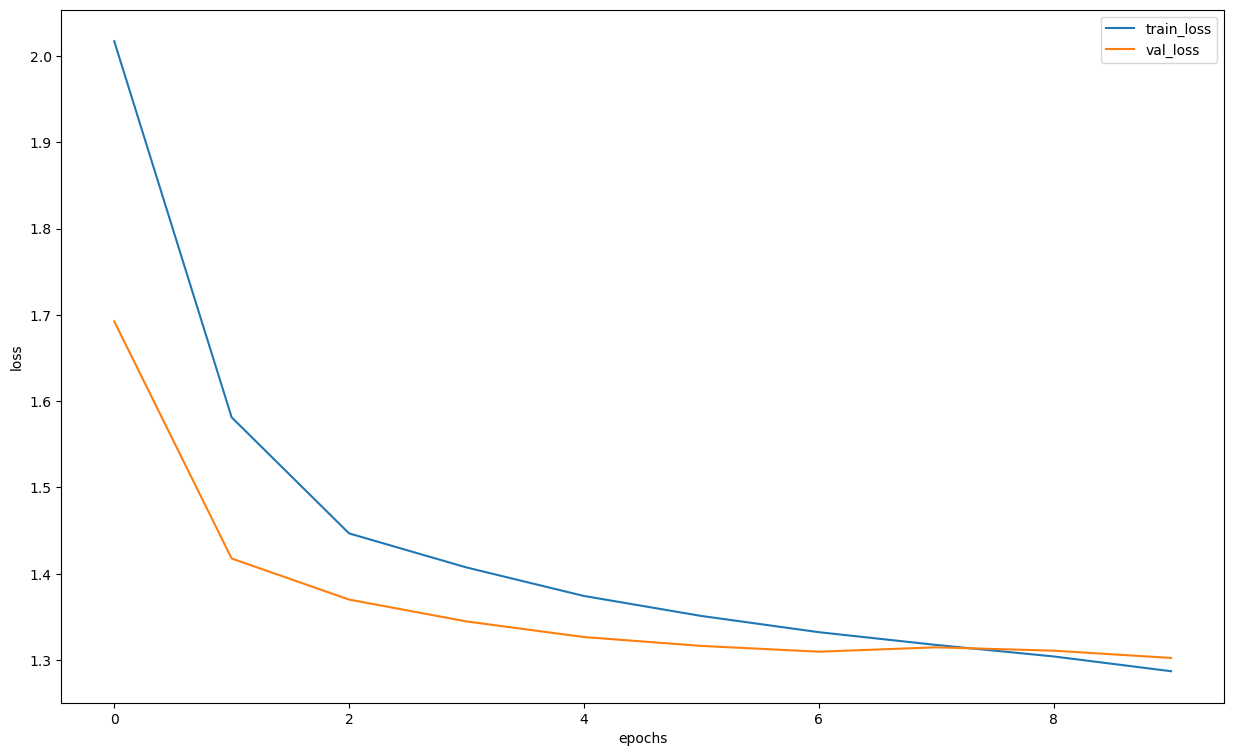

In [121]:
plt.figure(figsize=(15, 9))
plt.plot(train_losses, label="train_loss")
plt.plot(val_losses, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## TEST

In [124]:
def predict(model, test_loader):
    model.eval()
    with torch.no_grad():
        outputs = []
        for batch in test_loader:
            output = model(batch['input_ids'].to(device), batch['attention_mask'].to(device))
            output = nn.functional.softmax(output).cpu().detach().numpy()
            outputs.append(output)
        predictions = np.vstack(outputs)
    return predictions

In [125]:
predictions = predict(trained_model, test_dataloader)
predictions

array([[0.00923957, 0.00312193, 0.00456925, ..., 0.03423781, 0.07453338,
        0.859572  ],
       [0.00818832, 0.0034226 , 0.00390694, ..., 0.04206476, 0.10199883,
        0.82591635],
       [0.0052716 , 0.00612362, 0.00692834, ..., 0.44854856, 0.23289873,
        0.14532095],
       ...,
       [0.55128634, 0.24036413, 0.11760774, ..., 0.00668101, 0.00585685,
        0.00870579],
       [0.46565738, 0.27187276, 0.1561207 , ..., 0.00616434, 0.00519623,
        0.00772342],
       [0.80876946, 0.10750511, 0.04024369, ..., 0.00441575, 0.00458898,
        0.00803423]], dtype=float32)

In [126]:
predictions.shape

(25000, 8)

In [129]:
predictions_df = pd.DataFrame(predictions, columns=attributes)
predictions_df

,Rating_1,Rating_2,Rating_3,Rating_4,Rating_7,Rating_8,Rating_9,Rating_10
0,0.009240,0.003122,0.004569,0.004788,0.009938,0.034238,0.074533,0.859572
1,0.008188,0.003423,0.003907,0.003770,0.010733,0.042065,0.101999,0.825916
2,0.005272,0.006124,0.006928,0.011311,0.143597,0.448549,0.232899,0.145321
3,0.005079,0.004440,0.005213,0.007088,0.053398,0.252837,0.289475,0.382470
4,0.009671,0.008105,0.009170,0.013946,0.078803,0.235507,0.228300,0.416498
...,...,...,...,...,...,...,...,...
24995,0.038423,0.114286,0.283848,0.502241,0.031711,0.012809,0.007649,0.009033
24996,0.823088,0.102130,0.036892,0.019779,0.004004,0.003900,0.003882,0.006325
24997,0.551286,0.240364,0.117608,0.060976,0.008522,0.006681,0.005857,0.008706
24998,0.465657,0.271873,0.156121,0.079866,0.007399,0.006164,0.005196,0.007723


In [135]:
predictions_argmax = np.argmax(predictions_df.values, axis=1)
predictions_argmax

array([7, 7, 5, ..., 0, 0, 0])

In [130]:
true_labels = OHenc_test_df[attributes]
true_labels

,Rating_1,Rating_2,Rating_3,Rating_4,Rating_7,Rating_8,Rating_9,Rating_10
0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,1,0
2,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...
24995,0,0,0,1,0,0,0,0
24996,0,0,0,1,0,0,0,0
24997,0,0,1,0,0,0,0,0
24998,0,1,0,0,0,0,0,0


In [136]:
true_labels_argmax =  np.argmax(true_labels.values, axis=1)
true_labels_argmax

array([7, 6, 5, ..., 2, 1, 0])

In [132]:
from sklearn import metrics

In [137]:
print(metrics.accuracy_score(true_labels_argmax,predictions_argmax))

0.4808


In [139]:
true_labels_simple = np.where(true_labels_argmax < 4, 0, 1)
predictions_simple = np.where(predictions_argmax < 4, 0, 1)
true_labels_simple, predictions_simple

(array([1, 1, 1, ..., 0, 0, 0]), array([1, 1, 1, ..., 0, 0, 0]))

In [140]:
print(metrics.accuracy_score(true_labels_simple,predictions_simple))

0.93344


In [142]:
print(metrics.precision_score(true_labels_simple,predictions_simple))

0.927219681438259


In [143]:
print(metrics.recall_score(true_labels_simple,predictions_simple))

0.94072


In [144]:
print(metrics.f1_score(true_labels_simple,predictions_simple))

0.9339210547216266


In [141]:
metrics.confusion_matrix(true_labels_simple,predictions_simple)

array([[11577,   923],
       [  741, 11759]])

Text(0.5, 1.0, 'AUC ROC')

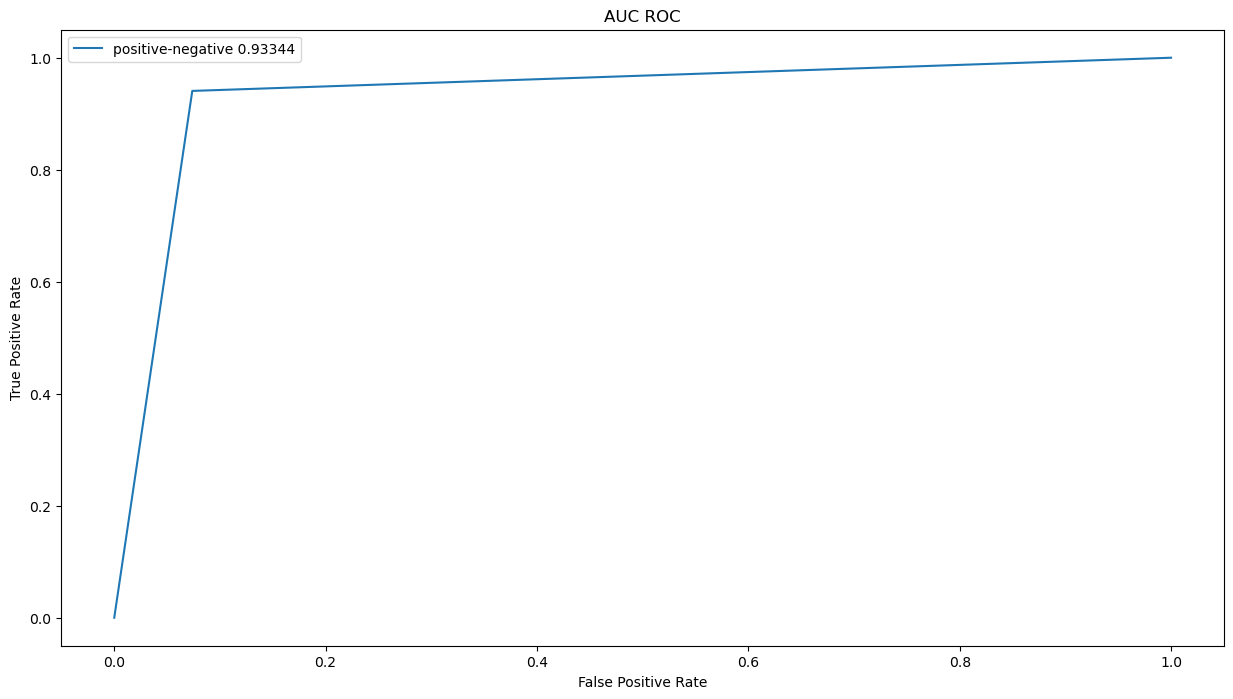

In [147]:
plt.figure(figsize=(15, 8))
fpr, tpr, _ = metrics.roc_curve(true_labels_simple, predictions_simple)
auc = metrics.roc_auc_score(true_labels_simple, predictions_simple)
plt.plot(fpr, tpr, label='%s %g' % ('positive-negative', auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.title('AUC ROC')